In [1]:
import sys
sys.path.append('./')

import former.former as former
from former.former import util
from former.former.transformers import NTransformer1D

from former.former.util import d, here, tic, toc

from NTdatasets.cumming.monocular import MultiDataset
from torch.utils.data import DataLoader, random_split, Subset

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
import tqdm

import numpy as np

device = torch.device('cuda:0')

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


In [2]:
embedding_size = 128
num_heads = 8
depth = 6
seq_length = 512
num_neurons = 95
context = 512
attention_type = 'default'

model = NTransformer1D(stim=embedding_size, heads=num_heads, depth=depth, seq_length=context, num_neurons=95)
model

NTransformer1D(
  (pos_embedding): Embedding(512, 128)
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
        (toqueries): Linear(in_features=128, out_features=128, bias=False)
        (tovalues): Linear(in_features=128, out_features=128, bias=False)
        (unifyheads): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (do): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
        (toqueries): Linear(in_features=128, out_fea

# load the data

In [3]:
# Load Data
num_lags = 10
expts = ['expt04']
datadir = './Mdata/'

batch_size = 2000

# TODO: we need to convert the items in the batch to sequences of stimuli,
#       instead of individual time points
#       Maybe just use time-embed, and reshape in the forward?
#       But, we also need to get the corresponding sequence of robs...
# TODO: we also need to change the model to predict a sequence of robs for each neuron,
#       not just a single set of robs for all the neurons


# we don't time embed to model the stimuli as a sequence with the transformer
dataset = MultiDataset(datadir=datadir, filenames=expts, include_MUs=False, time_embed=False)
print("%d cells, %d time steps."%(dataset.NC, dataset.NT))

train_inds = dataset.train_inds
val_inds = dataset.val_inds

train_ds = Subset(dataset, train_inds)
val_ds = Subset(dataset, val_inds)

train_dl = DataLoader(train_ds, 
                      batch_size=batch_size, 
                      shuffle=True, 
                      num_workers=0)
valid_dl = DataLoader(val_ds, 
                      batch_size=batch_size, 
                      shuffle=True, 
                      num_workers=0)

len(train_ds), len(val_ds)

Loading ['expt04']
Loading expt04
11 cells, 362504 time steps.


(274739, 68780)

# create the model

In [42]:
# from GPT-4

import torch
import torch.nn as nn

# Positional Encoding module to inject information about the relative or absolute position of the tokens in the sequence
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :x.size(1)]
        return self.dropout(x)


# Main Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.ninp = ninp
        self.nhead = nhead
        self.nhid = nhid
        self.nlayers = nlayers

        # Add a 1D convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=ninp, kernel_size=21, stride=1, padding=10)

        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(ninp, output_dim)
        self.relu = nn.ReLU()

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # Apply the 1D convolution to the input
        src = self.conv1(src.unsqueeze(1)).squeeze(1)
    
        src = src.permute(2, 0, 1)  # Change dimensions to (sequence_length, batch_size, features)
    
        src = src * np.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        output = self.relu(output)
        return output


# Hyperparameters
ntokens = 36  # input dimension (length of image vector)
ninp = 512   # embedding dimension
nhid = 256    # hidden dimension
nlayers = 2   # number of layers
nhead = 8     # number of attention heads
dropout = 0.2 # dropout rate
output_dim = 11 # output dimension (number of neurons)

# Create the model
model = TransformerModel(ntokens, output_dim, ninp, nhead, nhid, nlayers, dropout)

In [43]:
model.to(device)

TransformerModel(
  (conv1): Conv1d(1, 512, kernel_size=(21,), stride=(1,), padding=(10,))
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizab

In [44]:
dataset.train_inds, dataset.val_inds

(array([    20,     21,     22, ..., 362499, 362500, 362501]),
 array([   821,    822,    823, ..., 362098, 362099, 362100]))

In [45]:
stim = dataset[:10]['stim']
stim = stim.to(device)
model = model.to(device)

model(stim).shape

torch.Size([36, 10, 11])

In [46]:
max_spike_rate = 0
for idx in dataset.train_inds:
    max_spike_rate = max(max_spike_rate, dataset[idx]['robs'].max().item())
print(max_spike_rate)

7.0


# train the GPT-4 model

In [47]:
import torch.optim as optim

# Hyperparameters
batch_size = 2000
num_epochs = 5
learning_rate = 0.001

# Poisson loss function
def poisson_loss(output, target):
    return torch.mean(output - target * torch.log(output + 1e-9))

# Create data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(dataset, dataset.train_inds),
    batch_size=batch_size,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(dataset, dataset.val_inds),
    batch_size=batch_size,
    shuffle=False,
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in train_loader:
        stim = batch['stim'].to(device)
        robs = batch['robs'].to(device)
        
        # normalize the spike rate
        robs = robs / max_spike_rate

        optimizer.zero_grad()
        output = model(stim)

        # calculate loss with MSE loss
        loss = poisson_loss(output, robs)
        #loss = nn.MSELoss()(output, robs)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            stim = batch['stim'].to(device)
            robs = batch['robs'].to(device)

            # normalize the spike rate
            robs = robs / max_spike_rate

            output = model(stim)
            loss = poisson_loss(output, robs)

            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/5, Train Loss: 0.8211, Validation Loss: 0.8213
Epoch 2/5, Train Loss: 0.8210, Validation Loss: 0.8213
Epoch 3/5, Train Loss: 0.8208, Validation Loss: 0.8213
Epoch 4/5, Train Loss: 0.8210, Validation Loss: 0.8213
Epoch 5/5, Train Loss: 0.8210, Validation Loss: 0.8213


In [63]:
import matplotlib.pyplot as plt
stim = dataset[:1000]['stim']
stim = stim.to(device)
# plot the histogram of the predicted spike rates
pred = model(stim).detach().cpu().numpy().flatten()
_ = plt.hist(pred, bins=100)

RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 10.76 GiB total capacity; 9.44 GiB already allocated; 35.81 MiB free; 9.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# plot the predictions vs the ground truth

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Get all validation data
val_data = torch.utils.data.Subset(dataset, dataset.val_inds)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=2000, shuffle=False)

# Get predictions and ground truth values
robs_preds = []
robs_trues = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        stim = batch['stim'].to(device)
        robs_true = batch['robs'].cpu().numpy()
        # divide the spike rate by the max spike rate
        robs_true = robs_true / max_spike_rate
        
        robs_pred = model(stim).cpu().numpy()
        # multiply the spike rate by the max spike rate
        #robs_pred = robs_pred * max_spike_rate
        
        robs_preds.extend(robs_pred)
        robs_trues.extend(robs_true)

# Calculate R^2 value
r2 = r2_score(robs_true, robs_pred)
print(f'R^2 = {r2:.4f}')

robs_trues = np.array(robs_trues)
robs_preds = np.array(robs_preds)

print(np.min(robs_preds[:,1]), np.max(robs_preds[:,1]))
print(np.min(robs_trues[:,1]), np.max(robs_trues[:,1]))

# plot a histogram of the predictions
plt.figure(figsize=(10, 5))
plt.hist(robs_preds[:,1], bins=100, label='Predicted')
#plt.hist(robs_trues[:,1], bins=100, label='Actual')
plt.xlabel('Spike rate')
plt.ylabel('Count')
plt.title('Histogram of Predicted vs. Actual Spike Rates')
plt.legend()

/tmp/ipykernel_370786/1501634465.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  robs_preds = np.array(robs_preds)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

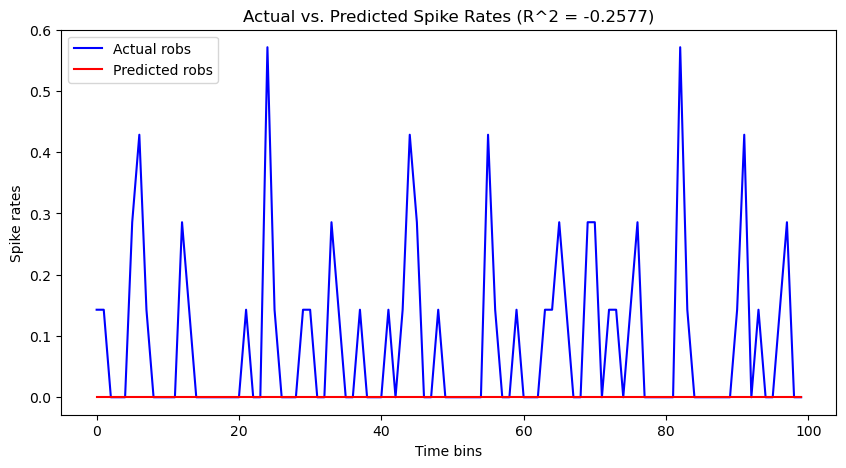

In [85]:
# Plot predictions and ground truth values
plt.figure(figsize=(10, 5))
plt.plot(robs_trues[:100,1], 'b-', label='Actual robs')
plt.plot(robs_preds[:100,1], 'r-', label='Predicted robs')
plt.xlabel('Time bins')
plt.ylabel('Spike rates')
plt.title(f'Actual vs. Predicted Spike Rates (R^2 = {r2:.4f})')
plt.legend()
plt.show()

In [149]:
mx = 360 # max sequence length # 360 / 10 frames = 36 pixels per frame
NC = 11
final = False

num_epochs = 2
max_pool = True
gradient_clipping = -1
lr = 0.0001
lr_warmup = 1000
depth = 6
num_heads = 6
stim_length = 36


model = NTransformer1D(stim=stim_length, heads=num_heads, depth=depth, seq_length=mx, num_neurons=dataset.NC, max_pool=max_pool)

model.to(device)

opt = torch.optim.Adam(lr=lr, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))

# training loop

In [150]:
def batch_to_sequences(batch, device):
    stim = batch['stim']
    robs = batch['robs']
    
    stim = stim.to(device)
    robs = robs.to(device)
    
    #print('stim', stim.shape)
    #print('robs', robs.shape)
    
    if stim.shape[0] < 1000:
        return None, None

    # reshape the batch stim into a small set of batches of the desired sequence length
    # 1000 x 36 --> 10 x 100 x 36
    # TODO: this is not correct,
    #  we want to stack the 36 dim vectors into a sequence
    #  making a 3D vector: batch_size x seq_len x 36
    stim_sequence = stim.reshape(10, 100, 36)
    
    # reshape the batch robs into a small set of batches of the desired sequence length
    # 1000 x 11 --> 100 x 110
    robs_sequence = robs.reshape(10, 100, 11)
    
    return stim_sequence, robs_sequence

In [155]:
losses = []
seen = 0
for e in range(1):
    print(f'\n epoch {e}')
    model.train(True)

    for batch in tqdm.tqdm(train_dl):
        opt.zero_grad()

        # convert the batch to sequences
        stim_sequence, robs_sequence = batch_to_sequences(batch, device)
        
        if stim_sequence is None:
            continue

        # TODO: I don't think the output is being properly normalized
        out = model(stim_sequence)
        print('out', torch.mean(out), torch.std(out))
        print('robs', torch.mean(robs_sequence), torch.std(robs_sequence))
        loss = F.mse_loss(out, robs_sequence)
        losses.append(loss.detach().cpu().numpy())

        loss.backward()

        # clip gradients
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        if gradient_clipping > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(),gradient_clipping)

        opt.step()
        sch.step()

        seen += stim_sequence.size(0)
        break

    with torch.no_grad():
        model.train(False)
        tot, cor= 0.0, 0.0

        for batch in tqdm.tqdm(valid_dl):
            stim_sequence, robs_sequence = batch_to_sequences(batch, device)
            if stim_sequence is None:
                continue
            out = model(stim_sequence)



 epoch 0


  0%|                                                                                                       | 0/275 [00:00<?, ?it/s]


out tensor(-2.4000, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0642, device='cuda:0', grad_fn=<StdBackward0>)
robs tensor(0.2726, device='cuda:0') tensor(0.6457, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 85.87it/s]


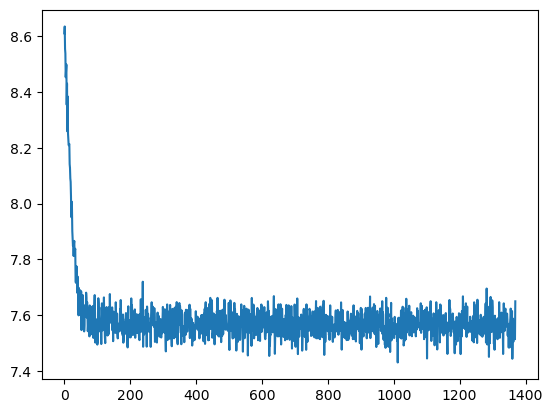

In [152]:
import matplotlib.pyplot as plt
plt.plot(losses)

# test the model

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 86.28it/s]


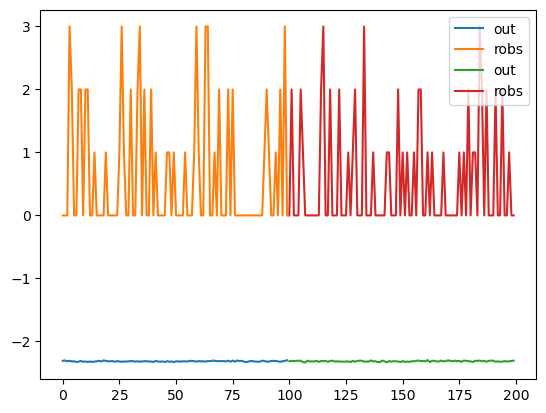

In [158]:
import matplotlib.pyplot as plt

outs = []
robs_sequences = []
for batch in tqdm.tqdm(valid_dl):
    stim_sequence, robs_sequence = batch_to_sequences(batch, device)
    if stim_sequence is None:
        continue
    robs_sequences.append(robs_sequence)
    out = model(stim_sequence)
    outs.append(out)
    
# normalize the outputs and robs
# normalized_outs = []
# normalized_robs_sequences = []
# for out, robs_sequence in zip(outs, robs_sequences):
#     out = out / torch.max(out)
#     robs_sequence = robs_sequence / torch.max(robs_sequence)
#     normalized_outs.append(out)
#     normalized_robs_sequences.append(robs_sequence)

i = 100
for out, robs_sequence in zip(outs, robs_sequences):
    plt.plot(range(i-100,i), out[0,:,1].cpu().detach().numpy(), label='out')
    plt.plot(range(i-100,i), robs_sequence[0,:,1].cpu().detach().numpy(), label='robs')
    i += 100
    if i > 200: break
plt.legend()